In [1]:
from ultis import *
import neal
from docplex.mp.model import Model
import matplotlib.pyplot as plt 
%matplotlib widget

### Create functions to define quadratic model

In [2]:
def define_variables(costs, model):
    var = set()
    for ijk in costs.keys():
        i, j, k = ijk[0], ijk[1], ijk[2]
        var.add((i, j))
        var.add((j, k))
    var = sorted(var, key=lambda x: (x[0], x[1]))
    x = model.binary_var_dict(var, name='x')
    return x

In [3]:
def create_model(costs, hits, hits_by_layers, alpha, model_path_out):
    NL = len(hits_by_layers.keys())
    print("Number of layers: ", NL)

    model = Model(name="Track finding")
    model.float_precision = 8
    x = define_variables(costs, model)
    ob_funct = model.sum(-w * alpha * x[(ijk[0], ijk[1])] * x[(ijk[1], ijk[2])] for ijk, w in costs.items())
    model.minimize(ob_funct)
    for h in hits:
        k = h.index
        constraint_out = []
        constraint_in = []
        for k_1 in x.keys():
            if ((h.layer_id < (NL - 1)) and (k_1[0] == k)):
                constraint_out.append(x[(k_1[0], k_1[1])])
            if ((h.layer_id > 0) and (k_1[1] == k)):
                constraint_in.append(x[(k_1[0], k_1[1])])
        if (len(constraint_out) > 0):
            model.add_constraint(model.sum(constraint_out) == 1)
        if (len(constraint_in) > 0):
            model.add_constraint(model.sum(constraint_in) == 1)

    model.export_as_lp(model_path_out)
    model.print_information()
    return model

In [4]:
def solve_lp(model, solution_path_out):
    model.solve(log_output=True)
    if model.solution == None:
        print("No solution!")
        return None
    else:
        model.solution.export(solution_path_out)

        f = open(solution_path_out)
        result = json.load(f)
        f.close()
        solution = result['CPLEXSolution']['variables']
        ob_value = float(result['CPLEXSolution']['header']['objectiveValue'])
        return ob_value, solution

### Display result

In [5]:
def display(hits, result, out=""):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    xs = []
    ys = []
    zs = []

    for h in hits:
        xs.append(h.x)
        ys.append(h.y)
        zs.append(h.z)
    ax.scatter(xs, ys, zs, marker='o', color='red')

    count_segments = 0
    for var in result:
        # print(var)
        x_i_j = var['name'].split('_')
        if 'x' in x_i_j[0] and round(float(var['value'])) == 1.0:
            count_segments += 1
            i = int(x_i_j[1])
            j = int(x_i_j[2])
            h1 = hits[i]
            h2 = hits[j]
            ax.plot(xs=[h1.x, h2.x], ys=[h1.y, h2.y], zs=[h1.z, h2.z], color='blue')
    print("No. segments by model :", count_segments)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.savefig(out)
    plt.show()


In [6]:
def run_script(no_tracks, beta_max, m, alpha):
    src_path = '../../src/data_selected'
    folder = '/'+ str(no_tracks)+'hits/known_track/'
    out_path = 'results'
    data_path = src_path + folder + 'hits.csv'
    figure_path_out = out_path + folder + "result_C_QCBM.PNG"
    check_path(out_path + folder)
    
    # read data
    print("Loading data...")
    start = time.time()
    hits_by_layers, hits = read_hits(data_path)
    end = time.time()
    print("Loaded data! Execution time: ", end - start)

    re_calculate = False
    costs_path_out = out_path + folder + "pi_" + str(A) + "costs.json"
    if os.path.exists(costs_path_out) == False:
        re_calculate = True
    if re_calculate:
        # calculate costs
        print("\n----Compute cost----")
        start = time.time()
        costs = get_costs(hits_by_layers, beta_max)
        end = time.time()
        print('Complete!. Execution time: ', end - start, 's')
    
        print("\n---Write cost out---")
        print("Path: ", costs_path_out)
        write_costs(costs, costs_path_out, m)
    
    # load data
    print("---Load cost---")
    costs = load_costs(costs_path_out)
    print("---Loaded cost---")

    print("\n ----Create LP----")
    model_path_out = out_path + folder + "model_C_QCBM.lp"
    model = create_model(costs, hits, hits_by_layers, alpha, model_path_out)
    print("----Created LP----")

    
    print("\n----Solving----")
    solution_path_out = out_path + folder + "solution_C_QCBM.json"
    ob_value, solution = solve_lp(model, solution_path_out)
    print("Objective value:", ob_value / alpha)
    cal_expected_value(hits, m)
    display(hits, solution, out=figure_path_out)
    

Choose number of tracks

Loading data...
Loaded data! Execution time:  0.034709930419921875
---Load cost---
---Loaded cost---

 ----Create LP----
Number of layers:  7
Model: Track finding
 - number of variables: 37021
   - binary=37021, integer=0, continuous=0
 - number of constraints: 2200
   - linear=2200
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQP
----Created LP----

----Solving----
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 118 rows and 1597 columns.
MIP Presolve added 47406 rows and 23703 columns.
Reduced MIP has 49488 rows, 59127 columns, and 163688 nonzeros.
Reduced MIP has 59127 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (39.30 ticks)
Found incumbent of value -3.492313 after 0.22 sec. (396.91 ticks)
Probing fixed 267 vars, tightened 0 bounds.
Probing changed sense of 4 constraints.
Probing time = 0.62 sec. (231.75 ticks)
Trie

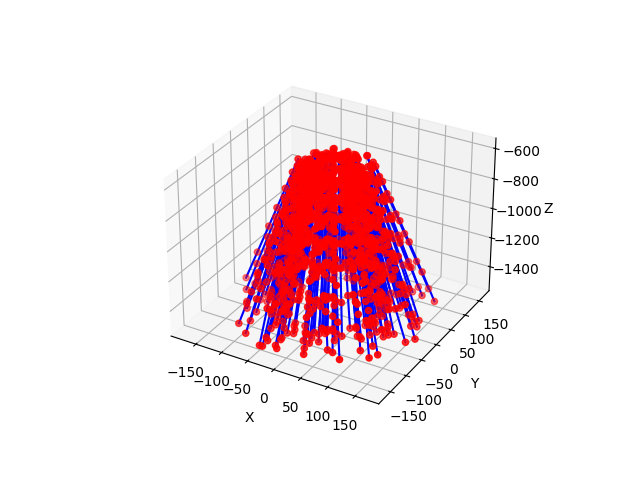

In [7]:
if __name__ == '__main__': # Keep this line if we want to run multiprocessing
    no_tracks = 200
    A = 300
    beta_max = math.pi / A
    m = 1
    alpha = 100
    run_script(no_tracks, beta_max, m, alpha)

In [ ]:
plt.close()